In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('antares_processed.csv')

In [3]:
data

,time,Mag
0,1917.624110,0.90
1,1917.632329,1.30
2,1917.638082,1.30
3,1917.640822,1.30
4,1917.659726,1.30
...,...,...
1205,2020.524137,0.86
1206,2020.526869,0.86
1207,2020.532333,0.86
1208,2020.548829,0.74


In [4]:
data['time']

0       1917.624110
1       1917.632329
2       1917.638082
3       1917.640822
4       1917.659726
           ...     
1205    2020.524137
1206    2020.526869
1207    2020.532333
1208    2020.548829
1209    2020.607136
Name: time, Length: 1210, dtype: float64

[Text(0, 0.5, 'V [mag]'), Text(0.5, 0, 'Time[years]')]

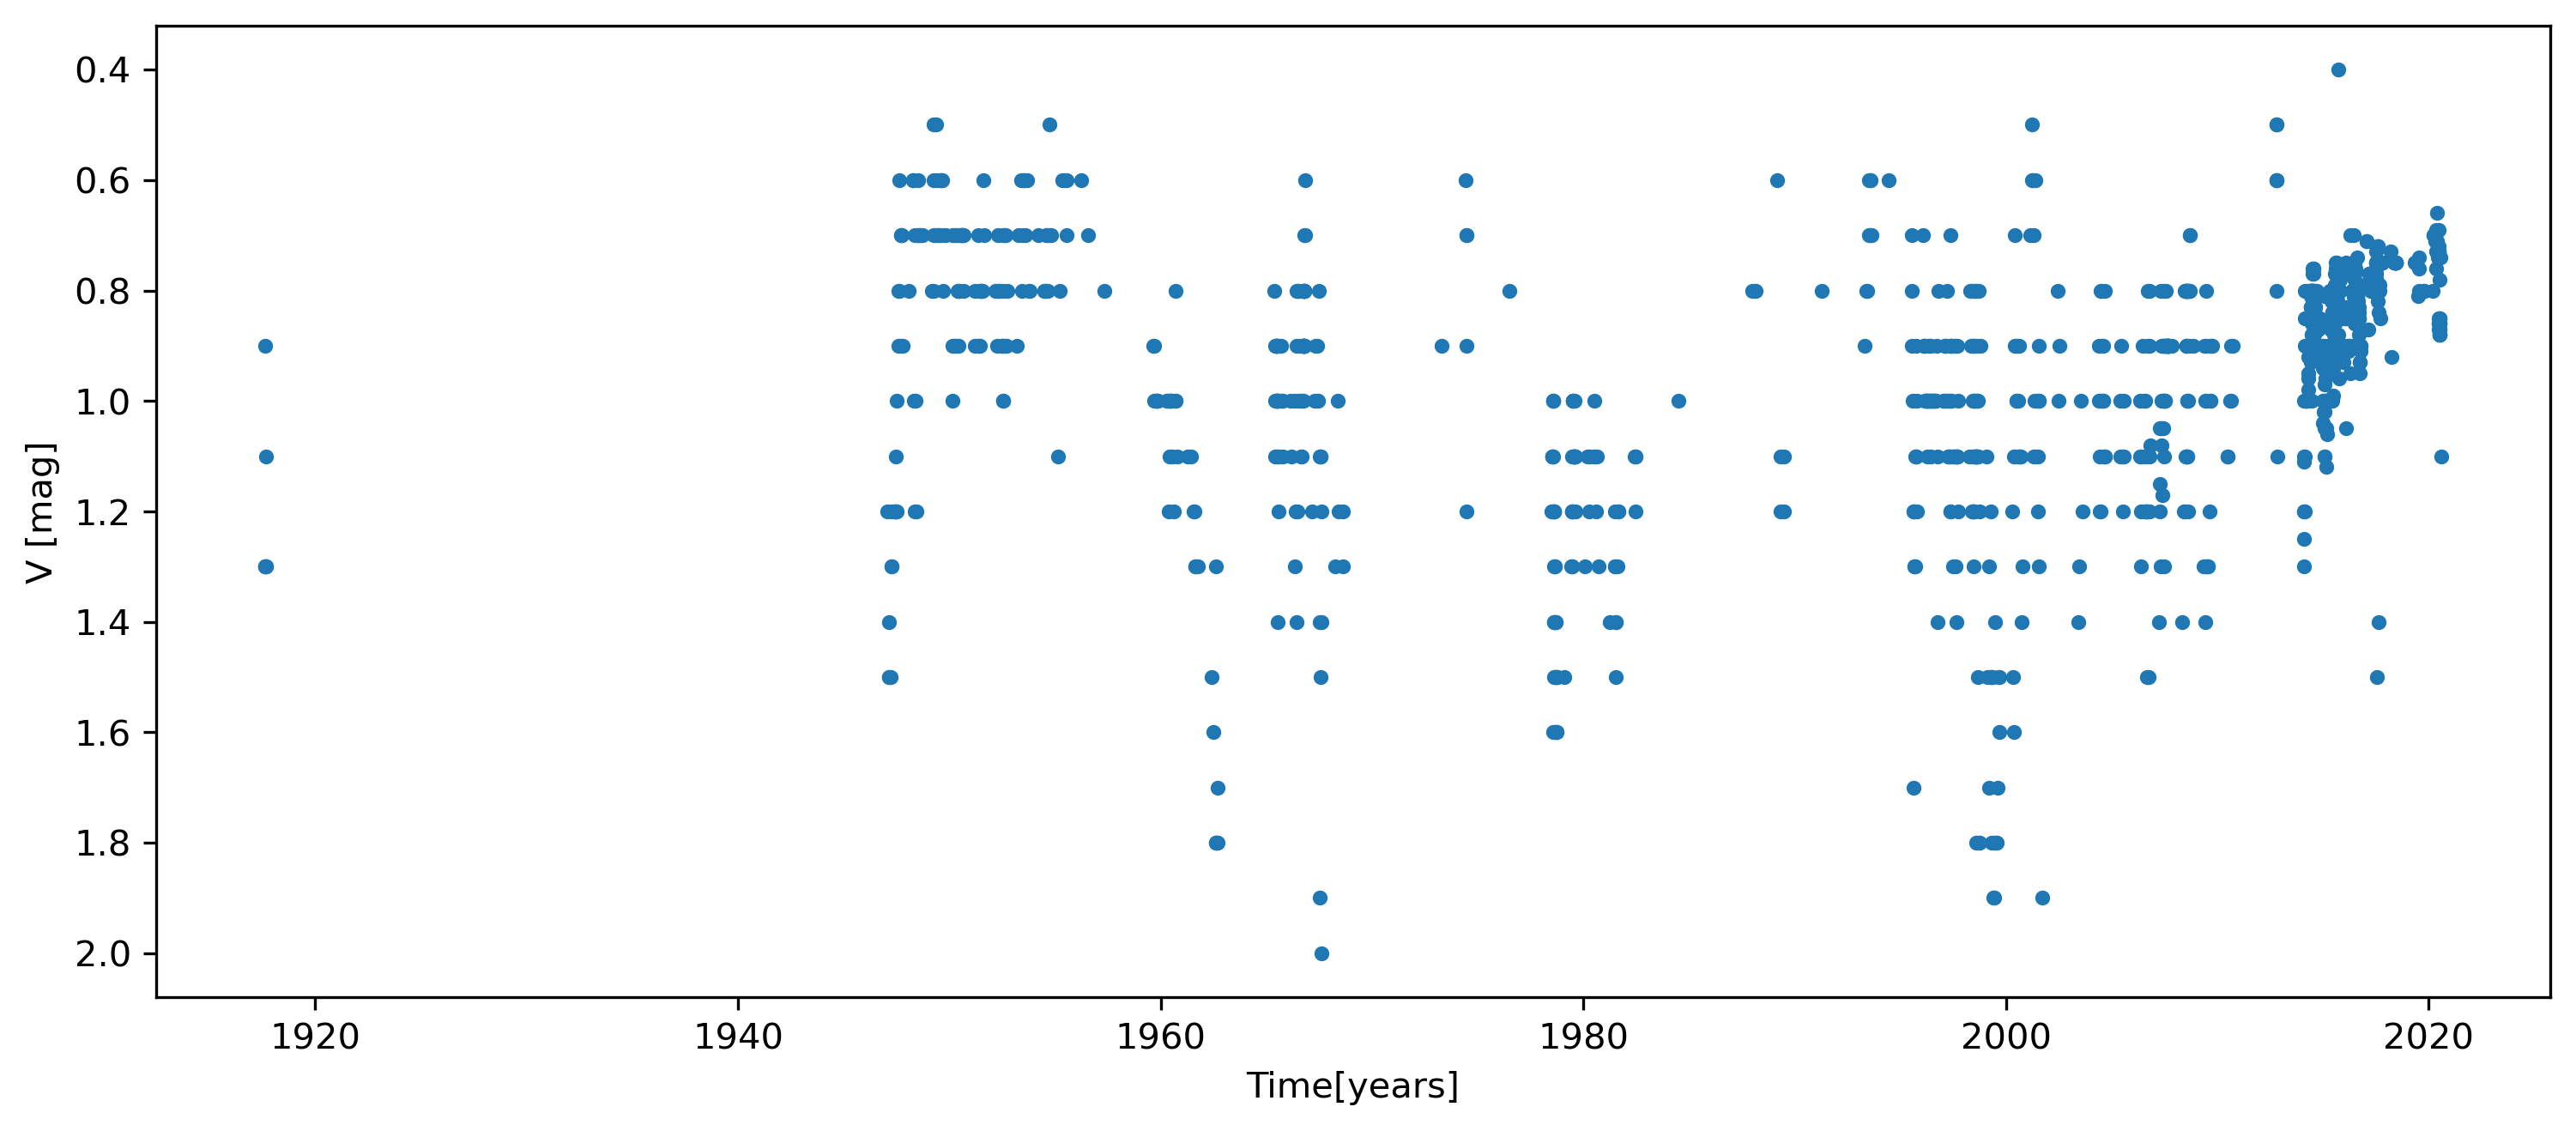

In [5]:
fig, ax = plt.subplots(figsize=(12,5), dpi=300)

plt.scatter(data['time'],data['Mag'], s=10)
plt.gca().invert_yaxis()

ax.set(xlabel='Time[years]', ylabel='V [mag]')

In [6]:
from astropy.timeseries import LombScargle

time = data['time'].values
mag = data['Mag'].values


nodip = time < 2019.5
time = time[nodip]
mag = mag[nodip]
print(nodip)

ls = LombScargle(time, mag) # dy=err

freq, power =ls.autopower()

[ True  True  True ... False False False]


[Text(0, 0.5, 'Power'),
 (0.0, 10.0),
 Text(0.5, 0, 'Frequency[yr$^{-1}$]'),
 Text(0.5, 1.0, 'Periodogram')]

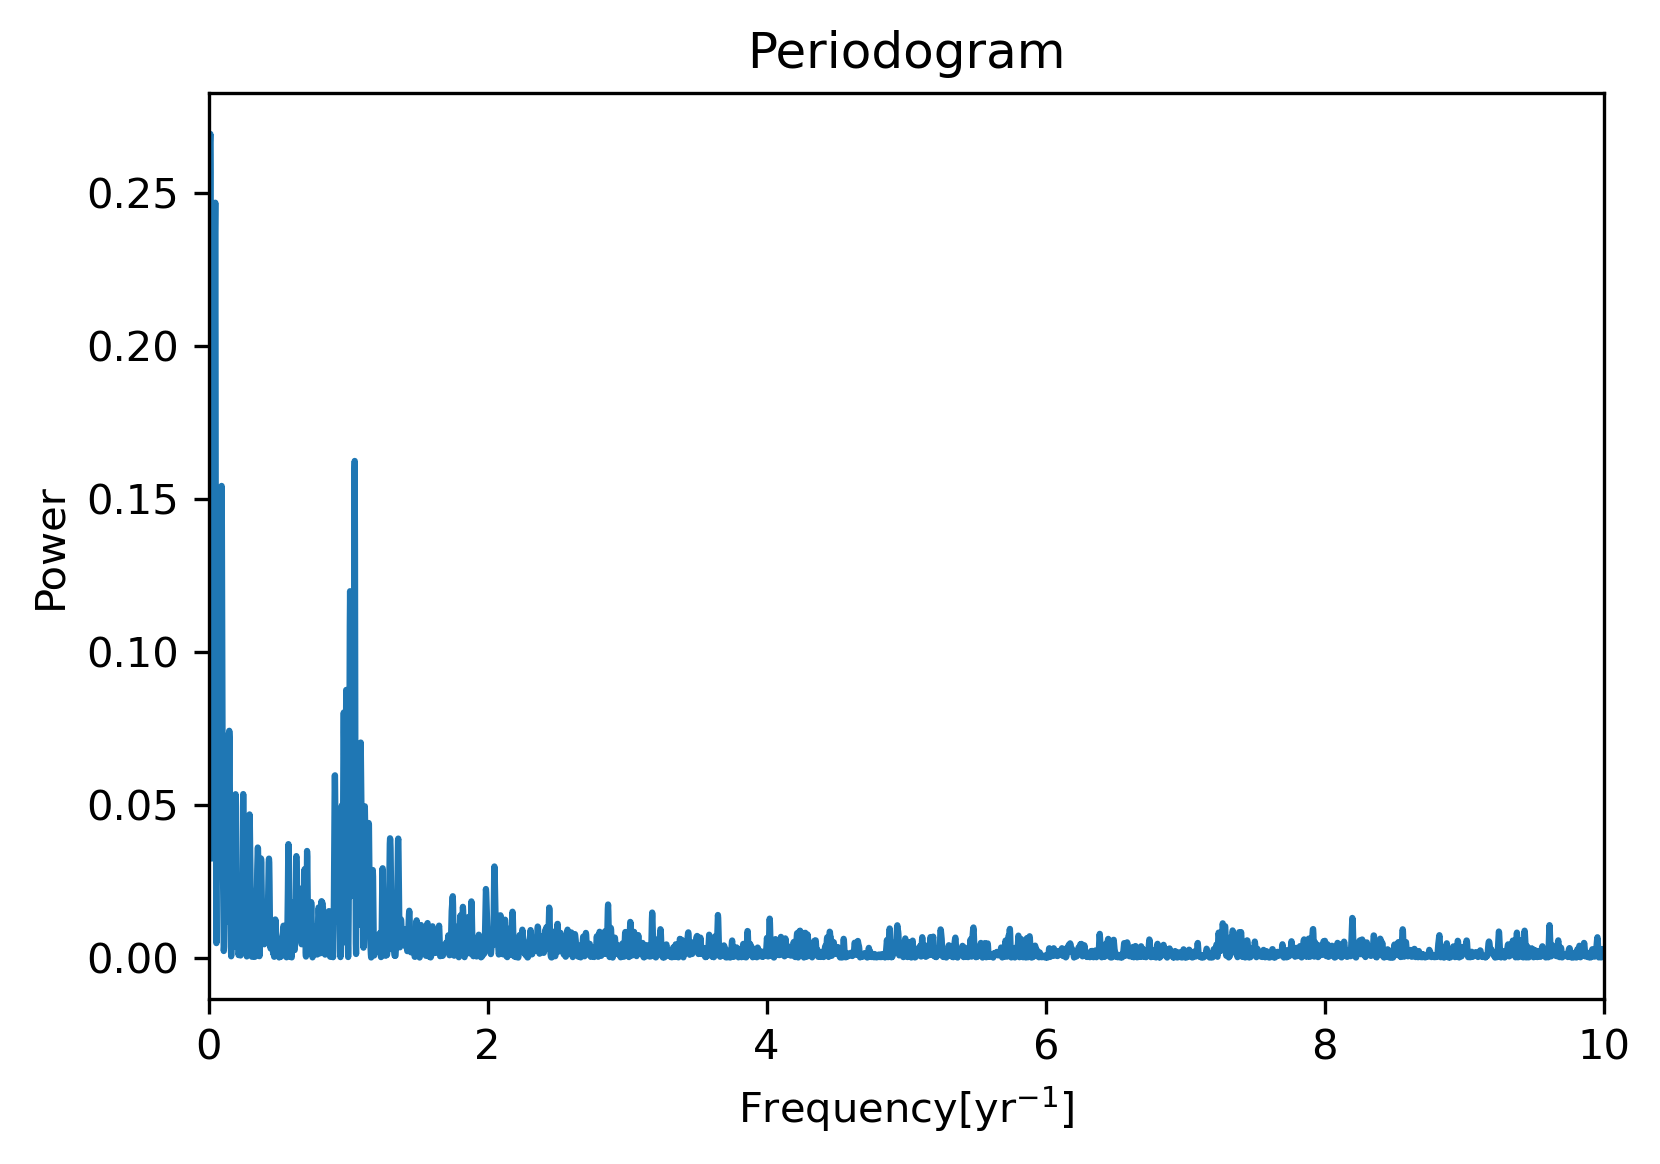

In [7]:
fig, ax = plt.subplots(dpi=300)

ax.plot(freq, power)
ax.set(xlabel='Frequency[yr$^{-1}$]', ylabel='Power',title= 'Periodogram', xlim=(0,10))

In [8]:
freq[np.argmax(power)]

0.012762879489979399

[Text(0, 0.5, 'Power'),
 Text(0.5, 0, 'Period[Days]'),
 Text(0.5, 1.0, 'Periodogram')]

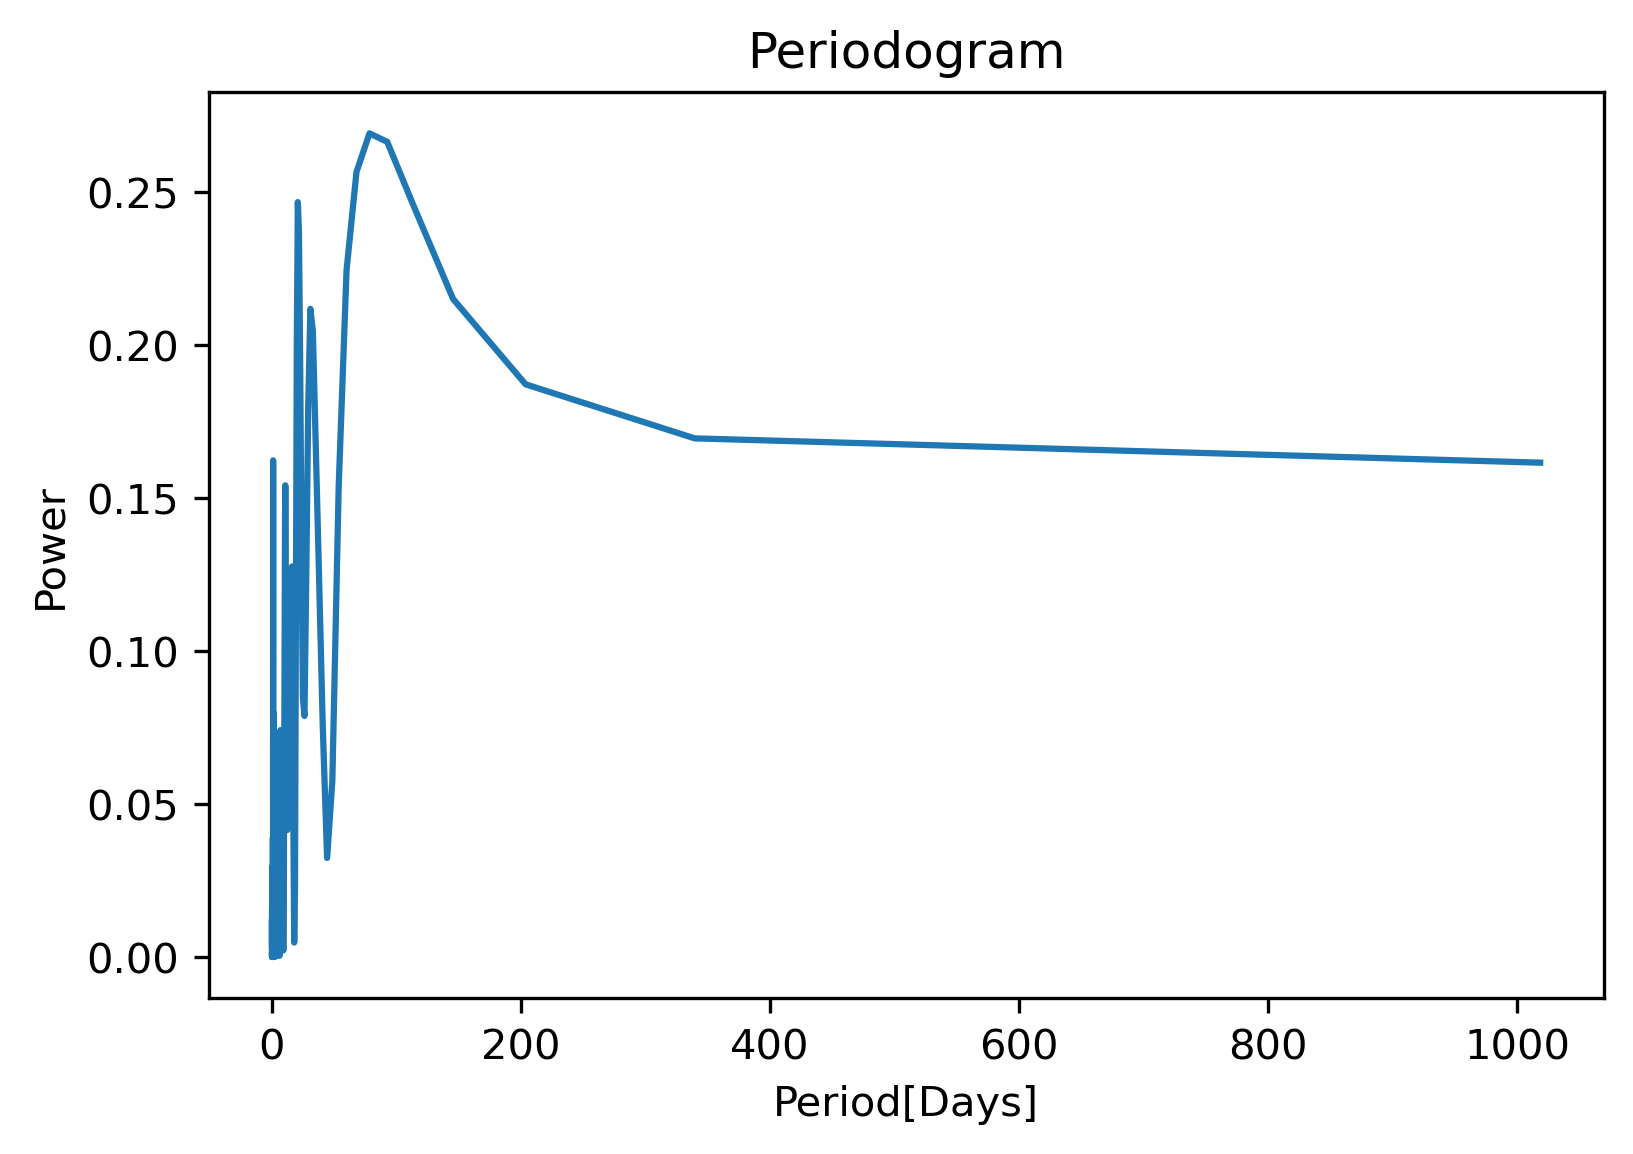

In [9]:
fig, ax = plt.subplots(dpi=300)

ax.plot(1/freq, power)
ax.set(xlabel='Period[Days]', ylabel='Power',title= 'Periodogram',)

In [10]:
def rednoise(frequency, alpha0, tau, gamma, alphaw):
    num = alpha0
    den = 1.0 + (2*np.pi*tau*frequency)**gamma
    return num/den + alphaw

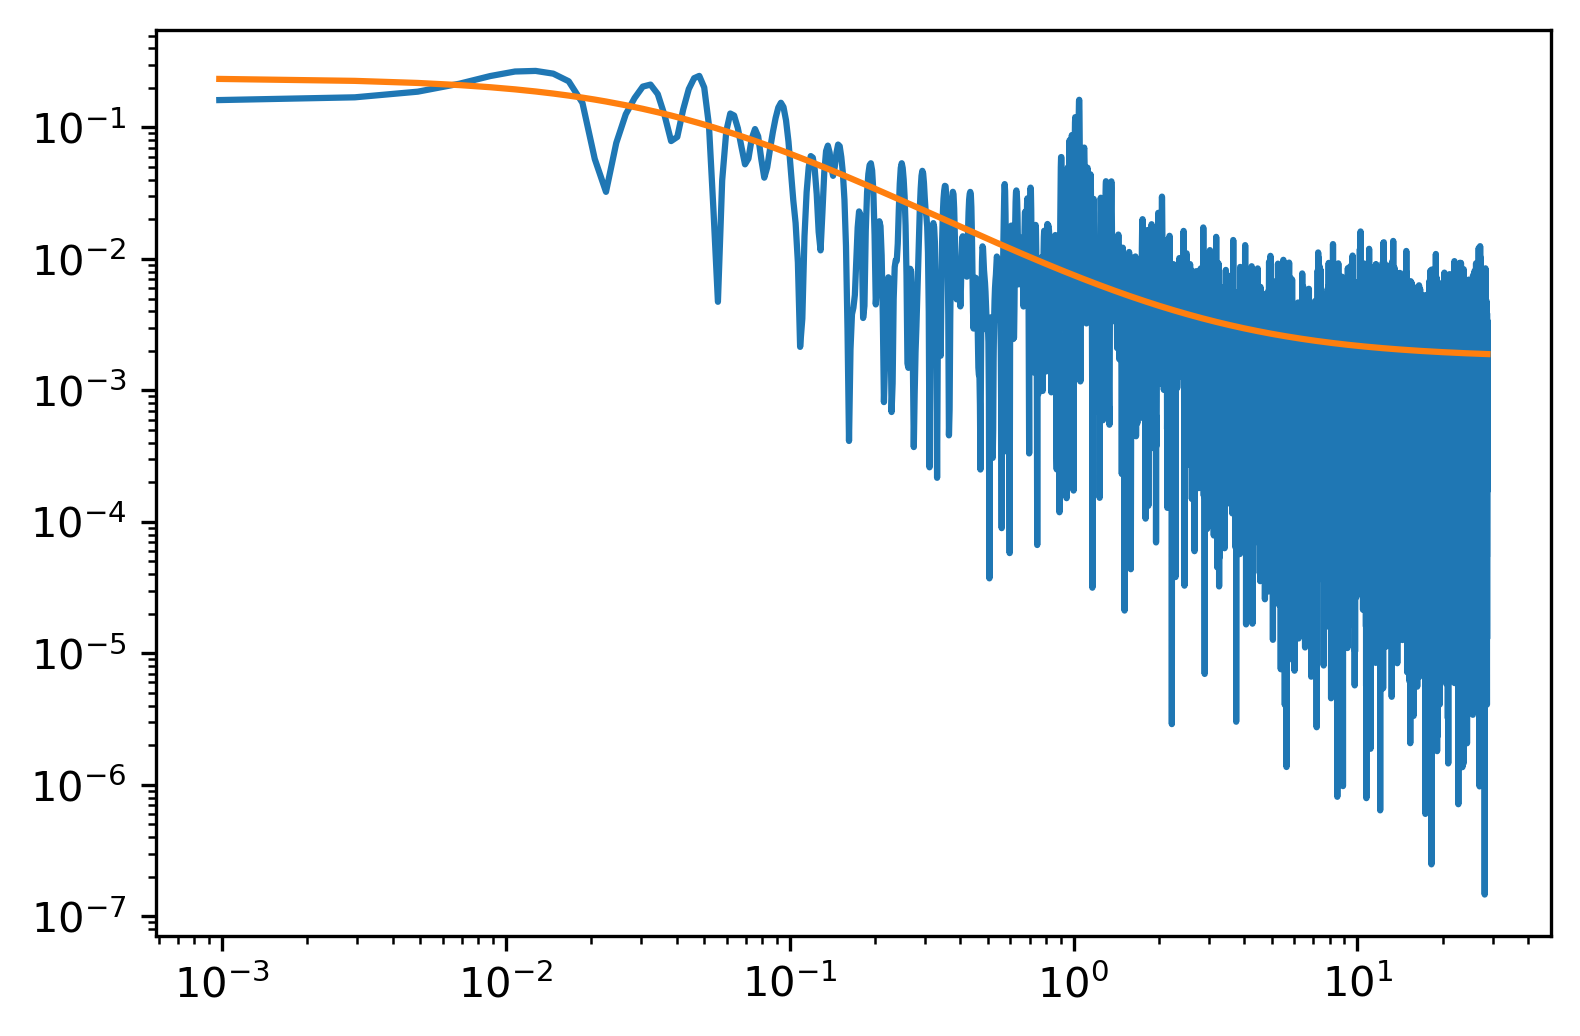

In [11]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(rednoise, freq, power, p0 = (0.05, 0.1, 2, 0.01))

fig = plt.figure(dpi=300)
plt.plot(freq, power)
plt.plot(freq,rednoise(freq, *popt))
plt.xscale('log')
plt.yscale('log')

[None,
 Text(0, 0.5, 'Power'),
 None,
 Text(0.5, 0, 'Period[Days]'),
 Text(0.5, 1.0, 'Periodogram')]

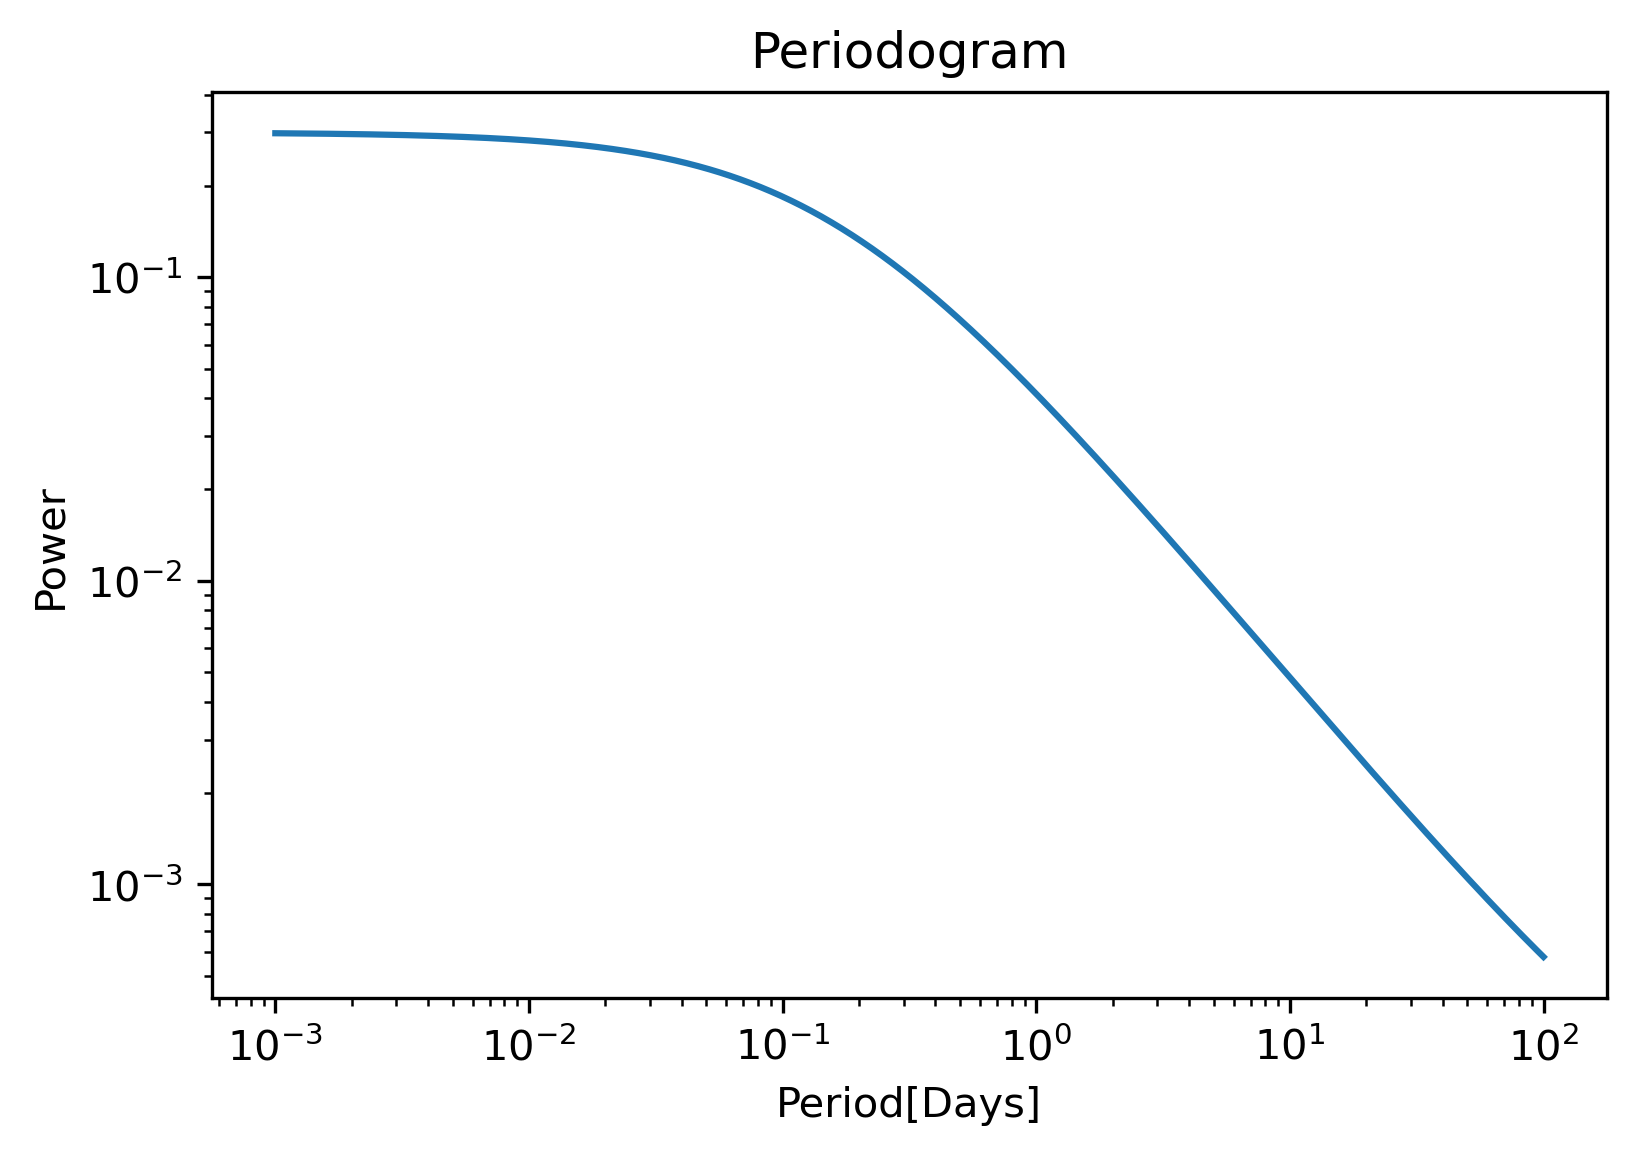

In [12]:
test_frequencies = np.logspace(-3, 2, 1000)
test_power = rednoise(test_frequencies, 0.3, 1, 1, 1e-4)

fig, ax = plt.subplots(dpi=300)

ax.plot(test_frequencies,test_power)
ax.set(xlabel='Period[Days]', ylabel='Power',title= 'Periodogram', xscale ='log', yscale = 'log')


[None,
 Text(0, 0.5, 'Power'),
 None,
 Text(0.5, 0, 'Frequency[yr$^{-1}$]'),
 Text(0.5, 1.0, 'Periodogram')]

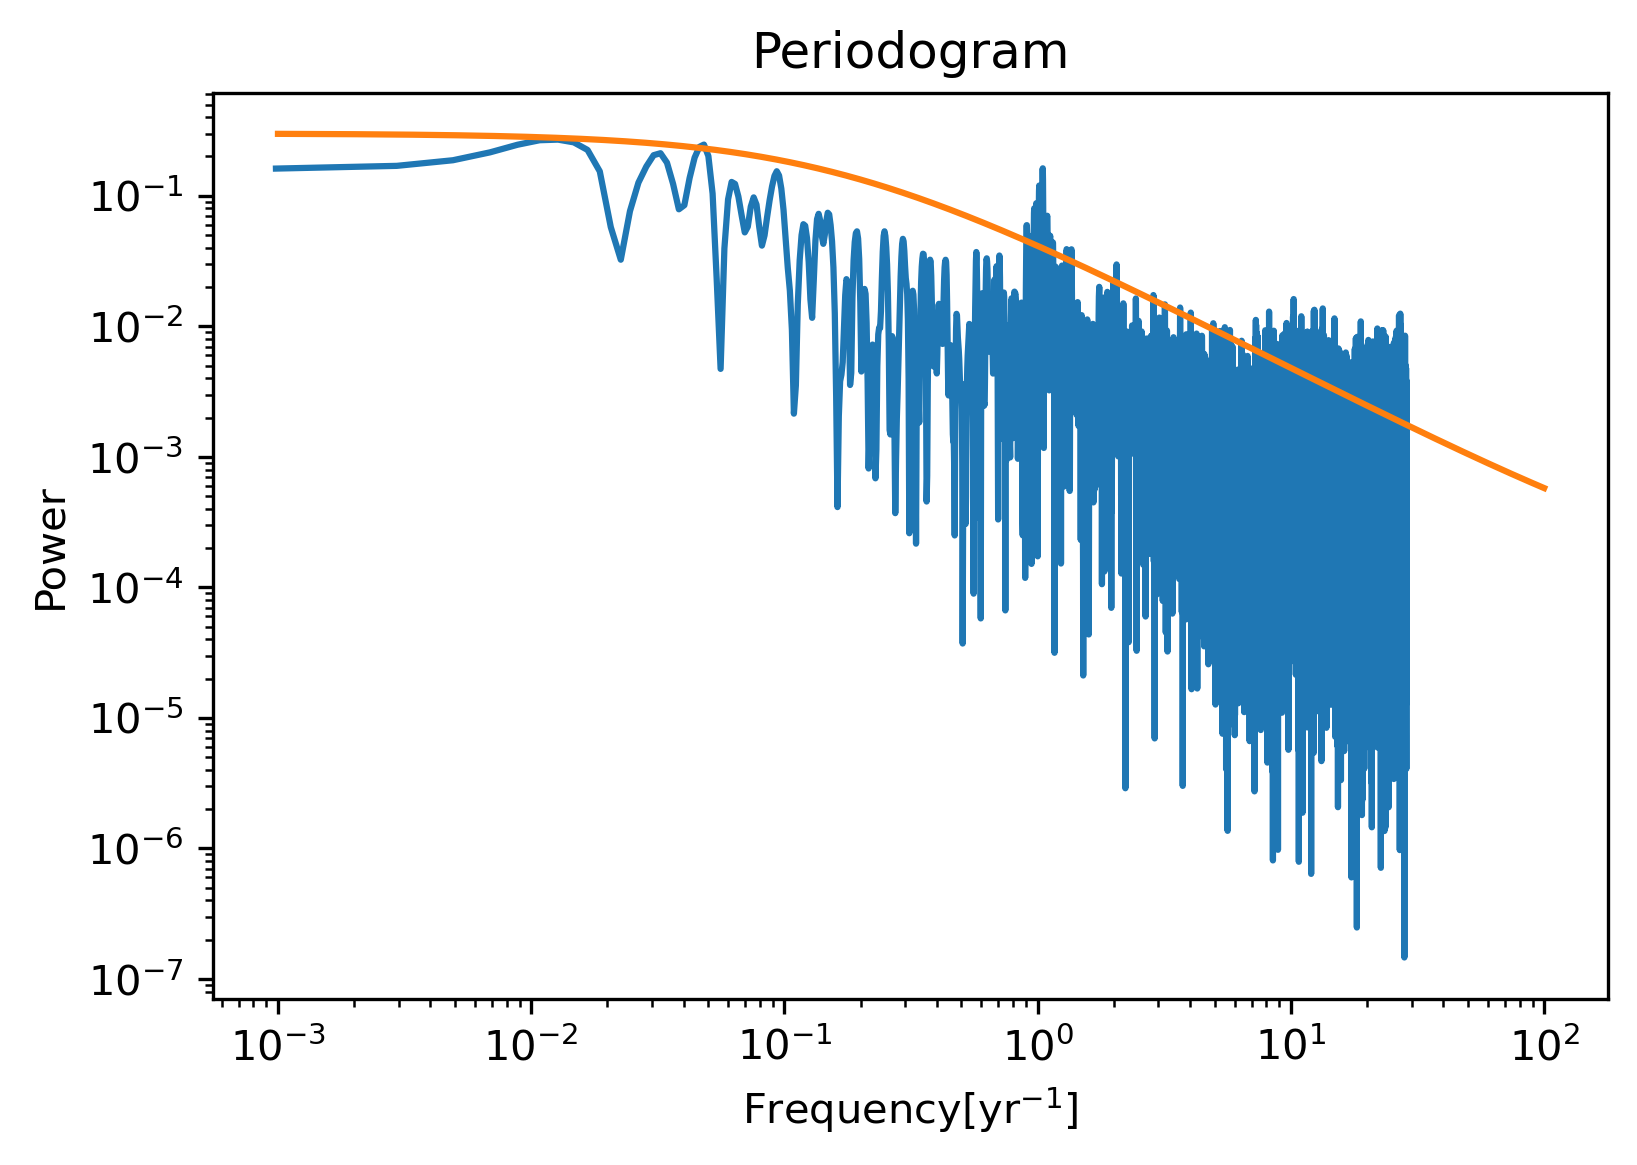

In [27]:
fig, ax = plt.subplots(dpi=300)

ax.plot(freq, power)
ax.plot(test_frequencies, test_power)

ax.set(xlabel='Frequency[yr$^{-1}$]', ylabel='Power',title= 'Periodogram', xscale= 'log', yscale='log')

In [28]:
from astropy.timeseries import LombScargle
ls = LombScargle(time, mag)
freq, power =ls.autopower()

In [29]:
def rednoise(frequency, alpha0, tau, gamma, alphaw):
    num = alpha0
    den = 1.0 + (2*np.pi*tau*frequency)**gamma
    return num/den + alphaw

In [30]:
def log_rednoise(frequency, alpha0, tau, gamma, alphaw):
    return np.log10(rednoise(frequency, alpha0, tau, gamma, alphaw))


In [31]:
def fit_rednoise(time, mag):
    # Input: time and magnitude arrays
    
    # Step 1: Calculate the Lomb-Scargle Periodogram

    ls = LombScargle(time, mag)
    freq, power =ls.autopower()
    
    # Step 1.5: Calculate the log of the lomb-scargle periodogram
    log_power = np.log10(power) 
    
    # Step 2: Curve fit red noise function
    popt,pcov = curve_fit(log_rednoise, freq, log_power, p0 = (0.05, 0.1, 2, 0.01))
    
    alpha0, tau, gamma, alphaw = popt
   
    return alpha0, tau, gamma, alphaw


In [32]:
fit_rednoise(time, mag)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


(0.1839621628397386,
 5.355346211785837,
 1.067663999734393,
 0.0007612101056841441)

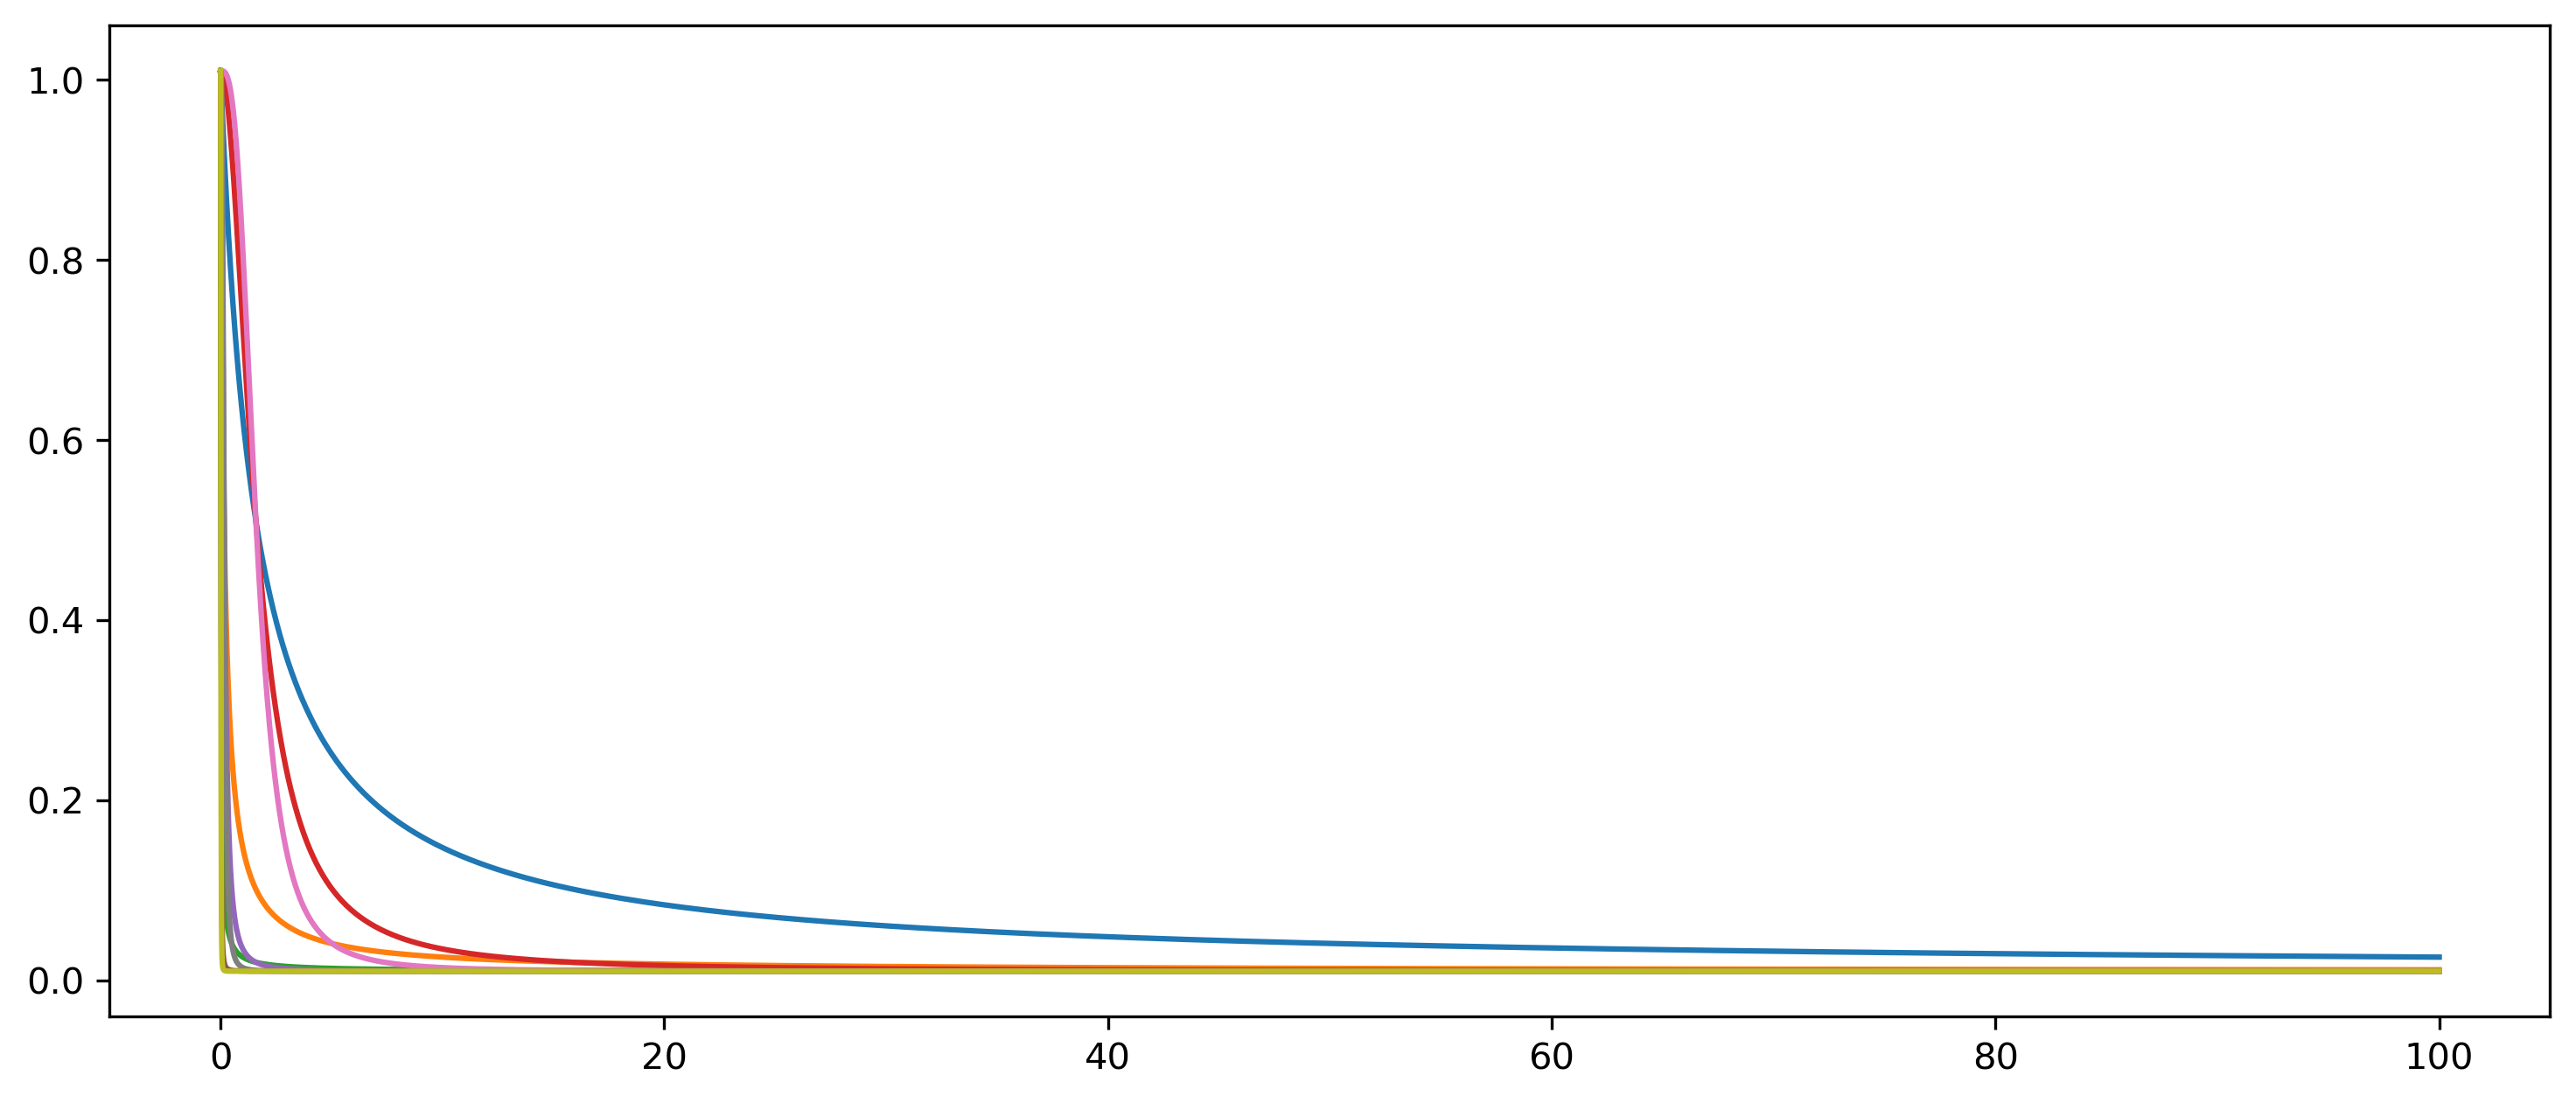

In [33]:
fig, ax = plt.subplots(figsize=(12,5), dpi=300)

gammas = [1,2,3]
tau = [0.1, 1, 10]
for g in gammas:
    for t in tau:
        test_power = rednoise(test_frequencies, 1, t, g, 1e-2)
        ax.plot(test_frequencies, test_power, label=fr'$\tau={t},\gamma={g}$')